In [1]:
import pandas as pd
import numpy as np

In [2]:
# Read Dataset
data = pd.read_csv("Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# maping the sentiment positive as 1 and negative as 0
data['sentiment'] = data['sentiment'].map({'positive' : 1, 'negative' : 0})
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Cleaning data

In [4]:
# Convert everything into lowercase
def to_lower(text):
    return text.lower()

In [5]:
# Remove HTML tags
import re
def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text)

In [6]:
# Remove Punctuation
import string
def remove_puntuation(text):
    text_nopunct = ''.join([i for i in text if i not in string.punctuation])
    return text_nopunct

In [7]:
# Remove stopwords
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Biman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# convert digit to number
import inflect 
q = inflect.engine()
def convert_number(text):
    new_str = []
    for word in text:
        if word.isdigit(): 
            temp = q.number_to_words(word) 
            new_str.append(temp)
        else: 
            new_str.append(word)
    return new_str

In [9]:
# Stemming
from nltk.stem import PorterStemmer
def stem_txt(text):
    ps = PorterStemmer()
    return " ".join([ps.stem(w) for w in text])

In [10]:
data['review'] = data['review'].apply(to_lower)
data['review'] = data['review'].apply(clean)
data['review'] = data['review'].apply(lambda x: remove_puntuation(x))
data['review'] = data['review'].apply(remove_stopwords)
data['review'] = data['review'].apply(convert_number)
data['review'] = data['review'].apply(stem_txt)

In [11]:
data['review'][0]

'one review mention watch one oz episod youll hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom

In [12]:
data.head()

,review,sentiment
0,one review mention watch one oz episod youll h...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic there famili littl boy jake think there ...,0
4,petter mattei love time money visual stun film...,1


In [13]:
X = data.iloc[:, 0].values
y = data.iloc[:, 1:].values

### train test split

In [14]:
from sklearn.model_selection import train_test_split
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(X,y,test_size=0.2,random_state=56)

##### Parameter to tunning

In [15]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

### model creation

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

In [17]:
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

In [21]:
# convert validation dataset to sequence and pad sequences
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

In [22]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 64)           320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 389,169
Trainable params: 389,169
Non-trainable params: 0
_________________________________________________________________


In [25]:
# fit model
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.33)

Epoch 1/10
838/838 - 121s - loss: 0.3930 - accuracy: 0.8275 - val_loss: 0.3627 - val_accuracy: 0.8361
Epoch 2/10
838/838 - 122s - loss: 0.2779 - accuracy: 0.8919 - val_loss: 0.3154 - val_accuracy: 0.8745
Epoch 3/10
838/838 - 121s - loss: 0.2307 - accuracy: 0.9129 - val_loss: 0.3486 - val_accuracy: 0.8597
Epoch 4/10
838/838 - 125s - loss: 0.1982 - accuracy: 0.9266 - val_loss: 0.3648 - val_accuracy: 0.8496
Epoch 5/10
838/838 - 124s - loss: 0.1706 - accuracy: 0.9373 - val_loss: 0.4032 - val_accuracy: 0.8655
Epoch 6/10
838/838 - 123s - loss: 0.1367 - accuracy: 0.9511 - val_loss: 0.4015 - val_accuracy: 0.8574
Epoch 7/10
838/838 - 125s - loss: 0.1153 - accuracy: 0.9600 - val_loss: 0.4637 - val_accuracy: 0.8533
Epoch 8/10
838/838 - 125s - loss: 0.0874 - accuracy: 0.9707 - val_loss: 0.5428 - val_accuracy: 0.8477
Epoch 9/10
838/838 - 120s - loss: 0.0717 - accuracy: 0.9765 - val_loss: 0.5956 - val_accuracy: 0.8546
Epoch 10/10
838/838 - 147s - loss: 0.0673 - accuracy: 0.9792 - val_loss: 0.5542 - 

In [26]:
# predict values
pred = model.predict(validation_padded)

In [30]:
pred

array([[1.6361773e-02],
       [2.6219917e-05],
       [4.9121141e-02],
       ...,
       [9.7605884e-01],
       [1.4811456e-03],
       [1.3909847e-02]], dtype=float32)

### Evalute model

In [34]:
# to plot model accuracy and loss
import matplotlib.pyplot as plt

def plot_history(history):
    
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', c='green', lw='2')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='orangered', lw='2')
    plt.title('Accuracy', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', c='green', lw='2')
    plt.plot(history.history['val_loss'], label='Validation Loss', c='orangered', lw='2')
    plt.title('Loss', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()

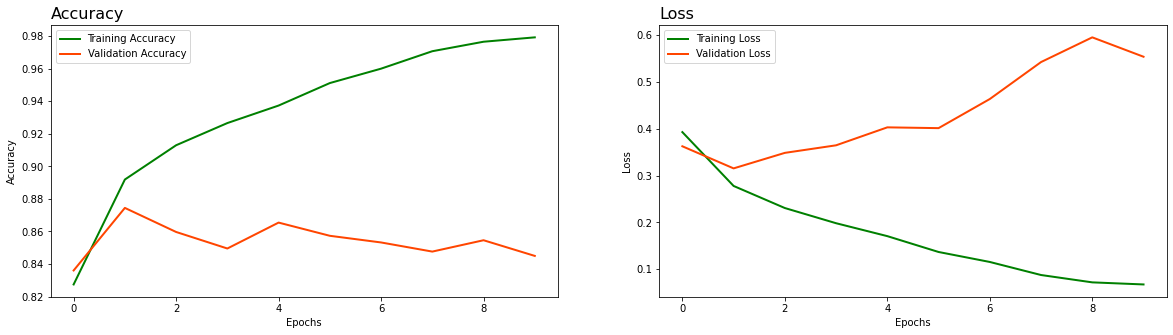

In [35]:
# plot history
plot_history(history)

In [41]:
import seaborn as sns
def plot_cm(pred, ticklabels, figsize):
    
    pred = pred.ravel()
    pred = np.round(pred)
      
    fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize))

    cm = confusion_matrix(validation_labels, pred)
    sns.heatmap(cm, annot=True, cbar=False, fmt='1d', cmap='Blues', ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(ticklabels)
    ax.set_yticklabels(ticklabels, rotation=0)

    plt.show()

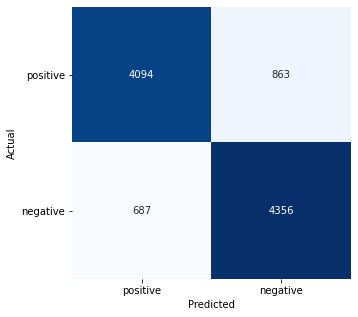

In [43]:
# plot confusion matrix
# plot_cm(pred, enc.classes_, 5)
plot_cm(pred, ['positive', 'negative'], 5)

In [49]:
# reviews on which we need to predict
sentence = ["The movie is good and hurt touching", 
            "I have never been seen a terrible movie like this one"]

In [50]:
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

In [51]:
# pad the sequence
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [52]:
# preict the label
print(model.predict(padded))

[[0.50286204]
 [0.39866674]]


In [68]:
precision = (4094)/(4094 + 687)
recall = (4094)/(4094 + 863)
precision, recall

(0.8563062120895211, 0.8259027637684083)

In [73]:
F1_score = (2 * 0.8563062120895211 * 0.8259027637684083)/(0.8563062120895211 + 0.8259027637684083)
F1_score

0.8408297391661532

## Convolution

### model creation

In [54]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [55]:
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [56]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          41088     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 364,209
Trainable params: 364,209
Non-trainable params: 0
_________________________________________________________________


In [57]:
# fit model
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.33)

Epoch 1/10
838/838 - 48s - loss: 0.4030 - accuracy: 0.8082 - val_loss: 0.3111 - val_accuracy: 0.8694
Epoch 2/10
838/838 - 48s - loss: 0.2250 - accuracy: 0.9098 - val_loss: 0.3105 - val_accuracy: 0.8723
Epoch 3/10
838/838 - 48s - loss: 0.1088 - accuracy: 0.9631 - val_loss: 0.3938 - val_accuracy: 0.8600
Epoch 4/10
838/838 - 46s - loss: 0.0324 - accuracy: 0.9918 - val_loss: 0.4743 - val_accuracy: 0.8671
Epoch 5/10
838/838 - 46s - loss: 0.0062 - accuracy: 0.9995 - val_loss: 0.5587 - val_accuracy: 0.8677
Epoch 6/10
838/838 - 48s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.6277 - val_accuracy: 0.8699
Epoch 7/10
838/838 - 47s - loss: 2.9319e-04 - accuracy: 1.0000 - val_loss: 0.6726 - val_accuracy: 0.8690
Epoch 8/10
838/838 - 40s - loss: 1.5624e-04 - accuracy: 1.0000 - val_loss: 0.7108 - val_accuracy: 0.8699
Epoch 9/10
838/838 - 39s - loss: 9.1936e-05 - accuracy: 1.0000 - val_loss: 0.7469 - val_accuracy: 0.8702
Epoch 10/10
838/838 - 39s - loss: 5.5710e-05 - accuracy: 1.0000 - val_loss: 0.7

In [58]:
# predict values
pred = model.predict(validation_padded)

### model evalution

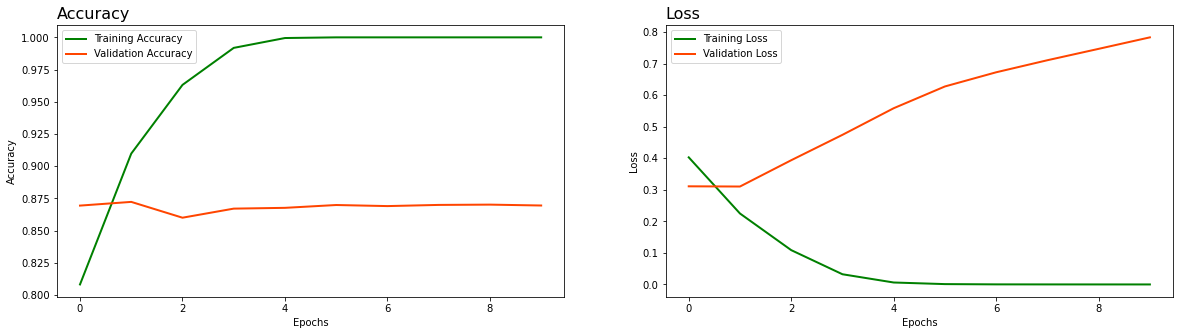

In [59]:
# plot history
plot_history(history)

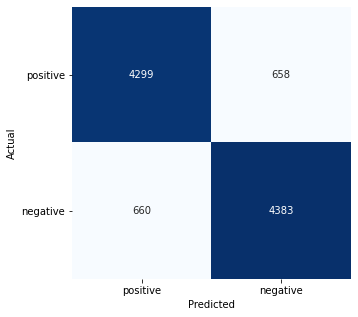

In [60]:
# plot confusion matrix
plot_cm(pred, ['positive', 'negative'], 5)

In [61]:
# reviews on which we need to predict
sentence = ["The movie is good and hurt touching", 
            "I have never been seen a terrible movie like this one"]

In [62]:
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

In [63]:
# pad the sequence
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [64]:
# preict the label
print(model.predict(padded))

[[0.9320642 ]
 [0.15514478]]


In [74]:
precision = (4299)/(4299 + 660)
recall = (4299)/(4299 + 658)
precision, recall

(0.8669086509376891, 0.8672584224329232)

In [75]:
F1_score = (2 * 0.8669086509376891 * 0.8672584224329232)/(0.8669086509376891 + 0.8672584224329232)
F1_score

0.8670835014118596